### **CMBS Modeling Framework**

#### Import libraries

In [18]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Set display options
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(formatter={'float': '{:.2f}'.format})

#### Define `Loan` class

In [11]:
@dataclass
class Loan:
    """Commercial mortgage loan class"""
    id: str
    original_balance: float
    current_balance: float
    rate: float  # Annual interest rate (decimal)
    term_months: int
    amortization_months: int
    origination_date: datetime
    maturity_date: datetime
    property_type: str
    location: str
    ltv: float  # Loan-to-value ratio
    dscr: float  # Debt service coverage ratio
    payment_frequency: str = 'monthly'  # monthly, quarterly, etc.
    is_defaulted: bool = False
    is_prepaid: bool = False
    probability_of_default: float = 0.0
    loss_given_default: float = 0.0
    
    def calculate_monthly_payment(self) -> float:
        """Calculate fixed monthly payment based on current balance"""
        if self.amortization_months == 0:  # Interest-only
            return self.current_balance * self.rate / 12
        
        monthly_rate = self.rate / 12
        return self.current_balance * monthly_rate * (1 + monthly_rate) ** self.amortization_months / \
               ((1 + monthly_rate) ** self.amortization_months - 1)
    
    def get_next_payment(self, period: int) -> Tuple[float, float, float]:
        """Returns (interest, principal, total) for the given payment period"""
        if self.is_defaulted:
            return 0, 0, 0
        
        if self.amortization_months == 0:  # Interest-only loan
            interest = self.current_balance * self.rate / 12
            return interest, 0, interest
        
        payment = self.calculate_monthly_payment()
        interest = self.current_balance * self.rate / 12
        principal = payment - interest
        
        # Handle balloon payment at maturity
        remaining_term = self.term_months - period
        if remaining_term == 0:
            principal = self.current_balance
            total = principal + interest
        else:
            total = payment
            
        return interest, principal, total
    
    def simulate_default(self, period: int, recovery_rate: float) -> Tuple[float, float]:
        """
        Simulate a default event
        Returns: (loss_amount, recovery_amount)
        """
        if self.is_defaulted:
            return 0, 0
            
        self.is_defaulted = True
        loss_amount = self.current_balance * (1 - recovery_rate)
        recovery_amount = self.current_balance * recovery_rate
        
        return loss_amount, recovery_amount
    
    def simulate_prepayment(self, period: int, prepayment_penalty: float = 0) -> float:
        """
        Simulate a prepayment event
        Returns: prepayment_amount including any penalties
        """
        if self.is_prepaid or self.is_defaulted:
            return 0
            
        self.is_prepaid = True
        prepayment_amount = self.current_balance * (1 + prepayment_penalty)
        
        return prepayment_amount

#### Define `Tranche` class

In [12]:
@dataclass
class Tranche:
    """CMBS tranche class"""
    id: str
    original_balance: float
    current_balance: float
    rate: float  # Annual coupon rate
    payment_priority: int  # Lower number = higher priority
    credit_enhancement: float  # % of deal subordinate to this tranche
    attachment_point: float  # % of deal subordinate to this tranche
    detachment_point: float  # % of deal at or subordinate to this tranche
    is_interest_only: bool = False  # True for IO strips
    
    def receive_payment(self, amount: float) -> float:
        """
        Apply payment to tranche
        Returns: remaining amount after payment
        """
        if self.is_interest_only:
            return amount  # IO tranches don't receive principal
        
        payment = min(amount, self.current_balance)
        self.current_balance -= payment
        return amount - payment

#### Define `CMBSStructure` class

In [13]:
class CMBSStructure:
    """CMBS deal structure with multiple tranches"""
    def __init__(self, name: str, cutoff_date: datetime, tranches: List[Tranche], loans: List[Loan]):
        self.name = name
        self.cutoff_date = cutoff_date
        self.tranches = sorted(tranches, key=lambda x: x.payment_priority)
        self.loans = loans
        self.current_period = 0
        self.original_balance = sum(loan.original_balance for loan in loans)
        self.payment_history = []
        
    def advance_period(self) -> Dict:
        """
        Advance one payment period, calculate all cash flows
        Returns: Dictionary with period results
        """
        self.current_period += 1
        period_date = self.cutoff_date + timedelta(days=30*self.current_period)
        
        # Collect loan payments
        total_interest = 0
        total_principal = 0
        total_loss = 0
        total_recovery = 0
        total_prepayment = 0
        
        # Process each loan
        for loan in self.loans:
            if loan.is_defaulted or loan.is_prepaid:
                continue
                
            # Check for default (simple random check based on PD)
            if np.random.random() < loan.probability_of_default / 12:  # Monthly PD
                loss, recovery = loan.simulate_default(self.current_period, 1 - loan.loss_given_default)
                total_loss += loss
                total_recovery += recovery
                continue
                
            # Check for prepayment (simple CPR model)
            cpr = 0.05  # Constant 5% annual prepayment rate for this example
            smm = 1 - (1 - cpr) ** (1/12)  # Convert annual to monthly
            if np.random.random() < smm:
                prepayment = loan.simulate_prepayment(self.current_period)
                total_prepayment += prepayment
                total_principal += loan.current_balance
                continue
                
            # Normal payment
            interest, principal, _ = loan.get_next_payment(self.current_period)
            total_interest += interest
            total_principal += principal
            
            # Update loan balance
            loan.current_balance -= principal
        
        # Distribute to tranches according to waterfall
        interest_distributed = 0
        principal_distributed = 0
        
        # First distribute interest (typically paid sequentially to all tranches)
        remaining_interest = total_interest
        for tranche in self.tranches:
            interest_due = tranche.current_balance * tranche.rate / 12
            interest_payment = min(interest_due, remaining_interest)
            remaining_interest -= interest_payment
            interest_distributed += interest_payment
        
        # Then distribute principal (typically paid sequentially to senior tranches first)
        remaining_principal = total_principal + total_recovery + total_prepayment
        for tranche in self.tranches:
            if remaining_principal <= 0:
                break
                
            principal_payment = tranche.receive_payment(remaining_principal)
            remaining_principal -= principal_payment
            principal_distributed += principal_payment
        
        # Record results
        result = {
            "period": self.current_period,
            "date": period_date,
            "interest_collected": total_interest,
            "principal_collected": total_principal,
            "losses": total_loss,
            "recoveries": total_recovery,
            "prepayments": total_prepayment,
            "interest_distributed": interest_distributed,
            "principal_distributed": principal_distributed,
            "remaining_balance": sum(loan.current_balance for loan in self.loans if not loan.is_defaulted),
            "tranche_balances": {t.id: t.current_balance for t in self.tranches}
        }
        
        self.payment_history.append(result)
        return result
    
    def run_to_maturity(self) -> pd.DataFrame:
        """
        Run the cash flow model until all loans are paid off or defaulted
        Returns: DataFrame with all period results
        """
        max_term = max(loan.term_months for loan in self.loans)
        
        while self.current_period < max_term:
            result = self.advance_period()
            
            # Check if all loans are paid off or defaulted
            active_loans = sum(1 for loan in self.loans if not loan.is_defaulted and not loan.is_prepaid 
                               and loan.current_balance > 0)
            if active_loans == 0:
                break
        
        return pd.DataFrame(self.payment_history)
    
    def calculate_tranche_metrics(self) -> pd.DataFrame:
        """Calculate performance metrics for each tranche"""
        metrics = []
        
        for tranche in self.tranches:
            expected_life = 0
            total_cashflow = 0
            
            for period, result in enumerate(self.payment_history):
                # Estimate cash flow to this tranche
                if period == 0:
                    previous_balance = tranche.original_balance
                else:
                    previous_balance = self.payment_history[period-1]["tranche_balances"][tranche.id]
                
                current_balance = result["tranche_balances"][tranche.id]
                principal_payment = previous_balance - current_balance
                interest_payment = previous_balance * tranche.rate / 12
                
                # Calculate weighted time for WAL
                expected_life += principal_payment * (period + 1)
                total_cashflow += principal_payment + interest_payment
            
            if tranche.original_balance > 0:
                wal = expected_life / tranche.original_balance
            else:
                wal = 0
                
            # Calculate yield and other metrics
            metrics.append({
                "tranche_id": tranche.id,
                "original_balance": tranche.original_balance,
                "current_balance": tranche.current_balance,
                "coupon": tranche.rate * 100,  # Convert to percentage
                "payment_priority": tranche.payment_priority,
                "credit_enhancement": tranche.credit_enhancement * 100,  # Convert to percentage
                "weighted_average_life": wal / 12,  # Convert to years
                "percent_paid": (1 - tranche.current_balance / tranche.original_balance) * 100 if tranche.original_balance > 0 else 0
            })
            
        return pd.DataFrame(metrics)
    
    def calculate_pool_metrics(self) -> Dict:
        """Calculate key metrics for the loan pool"""
        active_loans = [loan for loan in self.loans if not loan.is_defaulted]
        
        if not active_loans:
            return {"status": "All loans defaulted or paid off"}
            
        weighted_rate = sum(loan.current_balance * loan.rate for loan in active_loans) / \
                        sum(loan.current_balance for loan in active_loans)
                        
        weighted_dscr = sum(loan.current_balance * loan.dscr for loan in active_loans) / \
                        sum(loan.current_balance for loan in active_loans)
                        
        weighted_ltv = sum(loan.current_balance * loan.ltv for loan in active_loans) / \
                       sum(loan.current_balance for loan in active_loans)
        
        property_concentration = {}
        for loan in active_loans:
            if loan.property_type not in property_concentration:
                property_concentration[loan.property_type] = 0
            property_concentration[loan.property_type] += loan.current_balance
            
        total_balance = sum(loan.current_balance for loan in active_loans)
        for prop_type in property_concentration:
            property_concentration[prop_type] = property_concentration[prop_type] / total_balance * 100
            
        return {
            "current_balance": sum(loan.current_balance for loan in active_loans),
            "weighted_interest_rate": weighted_rate * 100,  # Convert to percentage
            "weighted_dscr": weighted_dscr,
            "weighted_ltv": weighted_ltv * 100,  # Convert to percentage
            "property_type_concentration": property_concentration,
            "number_of_active_loans": len(active_loans),
            "default_rate": (len(self.loans) - len(active_loans)) / len(self.loans) * 100
        }

#### Create sample CMBS

In [14]:
def create_sample_cmbs() -> CMBSStructure:
    """Create a sample CMBS structure for demonstration"""
    # Create sample loans
    loans = [
        Loan(
            id=f"L{i}",
            original_balance=10_000_000 + i * 500_000,
            current_balance=10_000_000 + i * 500_000,
            rate=0.045 + (i % 3) * 0.005,  # 4.5% to 5.5%
            term_months=120,  # 10 year term
            amortization_months=360,  # 30 year amortization
            origination_date=datetime(2023, 1, 1),
            maturity_date=datetime(2033, 1, 1),
            property_type=np.random.choice(["Office", "Retail", "Multifamily", "Industrial", "Hotel"]),
            location=np.random.choice(["NY", "CA", "TX", "FL", "IL"]),
            ltv=0.65 + (i % 5) * 0.03,  # 65% to 77%
            dscr=1.3 + (i % 4) * 0.1,  # 1.3x to 1.6x
            probability_of_default=0.01 + (i % 10) * 0.002,  # 1% to 2.8%
            loss_given_default=0.3 + (i % 5) * 0.05  # 30% to 50%
        )
        for i in range(20)  # 20 loans
    ]
    
    # Total pool size
    pool_size = sum(loan.original_balance for loan in loans)
    
    # Create tranches (simplified structure)
    tranches = [
        Tranche(
            id="A",
            original_balance=pool_size * 0.70,  # 70% of pool
            current_balance=pool_size * 0.70,
            rate=0.04,  # 4% coupon
            payment_priority=1,
            credit_enhancement=0.30,  # 30% CE
            attachment_point=0.30,
            detachment_point=1.0
        ),
        Tranche(
            id="B",
            original_balance=pool_size * 0.10,  # 10% of pool
            current_balance=pool_size * 0.10,
            rate=0.045,  # 4.5% coupon
            payment_priority=2,
            credit_enhancement=0.20,  # 20% CE
            attachment_point=0.20,
            detachment_point=0.30
        ),
        Tranche(
            id="C",
            original_balance=pool_size * 0.10,  # 10% of pool
            current_balance=pool_size * 0.10,
            rate=0.055,  # 5.5% coupon
            payment_priority=3,
            credit_enhancement=0.10,  # 10% CE
            attachment_point=0.10,
            detachment_point=0.20
        ),
        Tranche(
            id="D",
            original_balance=pool_size * 0.10,  # 10% of pool
            current_balance=pool_size * 0.10,
            rate=0.07,  # 7% coupon
            payment_priority=4,
            credit_enhancement=0.0,  # 0% CE (first loss piece)
            attachment_point=0.0,
            detachment_point=0.10
        )
    ]
    
    # Create the CMBS structure
    cmbs = CMBSStructure(
        name="Sample CMBS 2023-1",
        cutoff_date=datetime(2023, 1, 1),
        tranches=tranches,
        loans=loans
    )
    
    return cmbs

#### Run CMBS Modeling

In [15]:
def main():
    """Main function to demonstrate CMBS modeling"""
    # Create sample CMBS
    cmbs = create_sample_cmbs()
    
    # Run the cash flow model for 2 years (24 months)
    max_periods = 24
    results = []
    
    for _ in range(max_periods):
        period_result = cmbs.advance_period()
        results.append(period_result)
    
    # Display results
    print(f"CMBS: {cmbs.name}")
    print(f"Original Pool Balance: ${cmbs.original_balance:,.2f}")
    print(f"Current Pool Balance: ${sum(loan.current_balance for loan in cmbs.loans if not loan.is_defaulted):,.2f}")
    print(f"Cumulative Losses: ${sum(result['losses'] for result in results):,.2f}")
    print(f"Cumulative Recoveries: ${sum(result['recoveries'] for result in results):,.2f}")
    print("\nTranche Performance:")
    
    tranche_metrics = cmbs.calculate_tranche_metrics()
    print(tranche_metrics)
    
    print("\nPool Metrics:")
    pool_metrics = cmbs.calculate_pool_metrics()
    for key, value in pool_metrics.items():
        if isinstance(value, dict):
            print(f"{key}:")
            for subkey, subvalue in value.items():
                print(f"  {subkey}: {subvalue:.2f}%")
        else:
            if isinstance(value, float):
                print(f"{key}: {value:.2f}")
            else:
                print(f"{key}: {value}")

if __name__ == "__main__":
    main()

CMBS: Sample CMBS 2023-1
Original Pool Balance: $295,000,000.00
Current Pool Balance: $274,371,324.44
Cumulative Losses: $4,532,048.62
Cumulative Recoveries: $8,416,661.71

Tranche Performance:
  tranche_id  original_balance  current_balance  coupon  payment_priority  \
0          A      206500000.00     160439419.54    4.00                 1   
1          B       29500000.00             0.00    4.50                 2   
2          C       29500000.00             0.00    5.50                 3   
3          D       29500000.00             0.00    7.00                 4   

   credit_enhancement  weighted_average_life  percent_paid  
0               30.00                   0.08         22.31  
1               20.00                   0.17        100.00  
2               10.00                   0.17        100.00  
3                0.00                   0.17        100.00  

Pool Metrics:
current_balance: 274371324.44
weighted_interest_rate: 5.00
weighted_dscr: 1.45
weighted_ltv: 71.34
p

#### Visualizations

Visualizations created and saved.


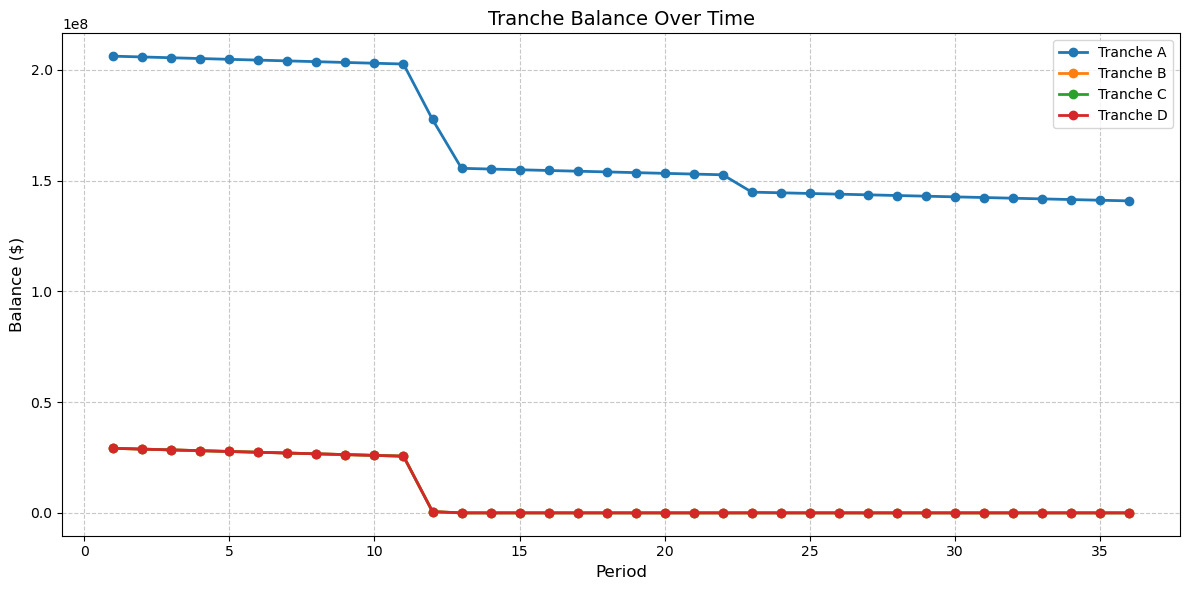

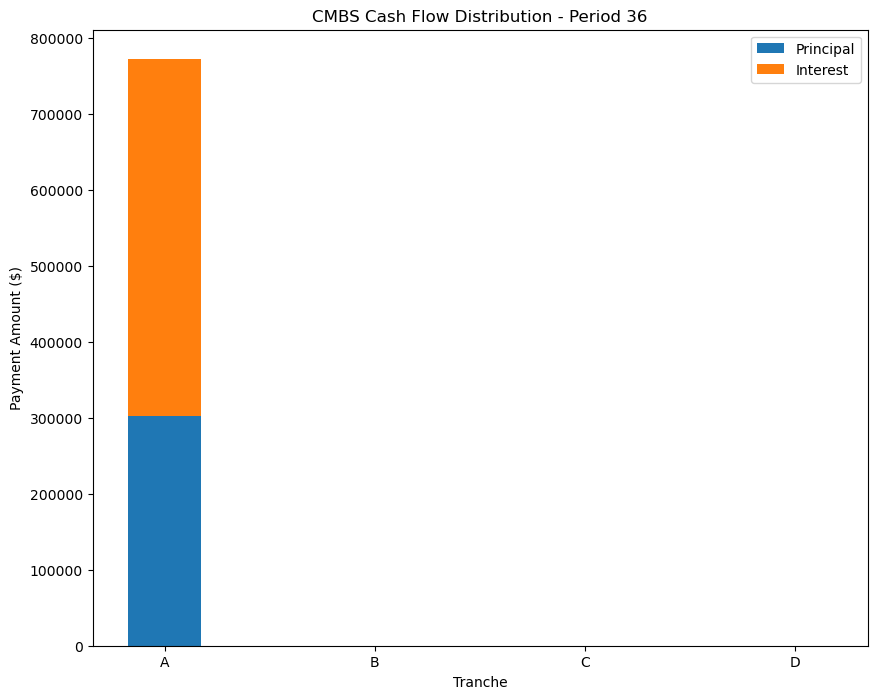

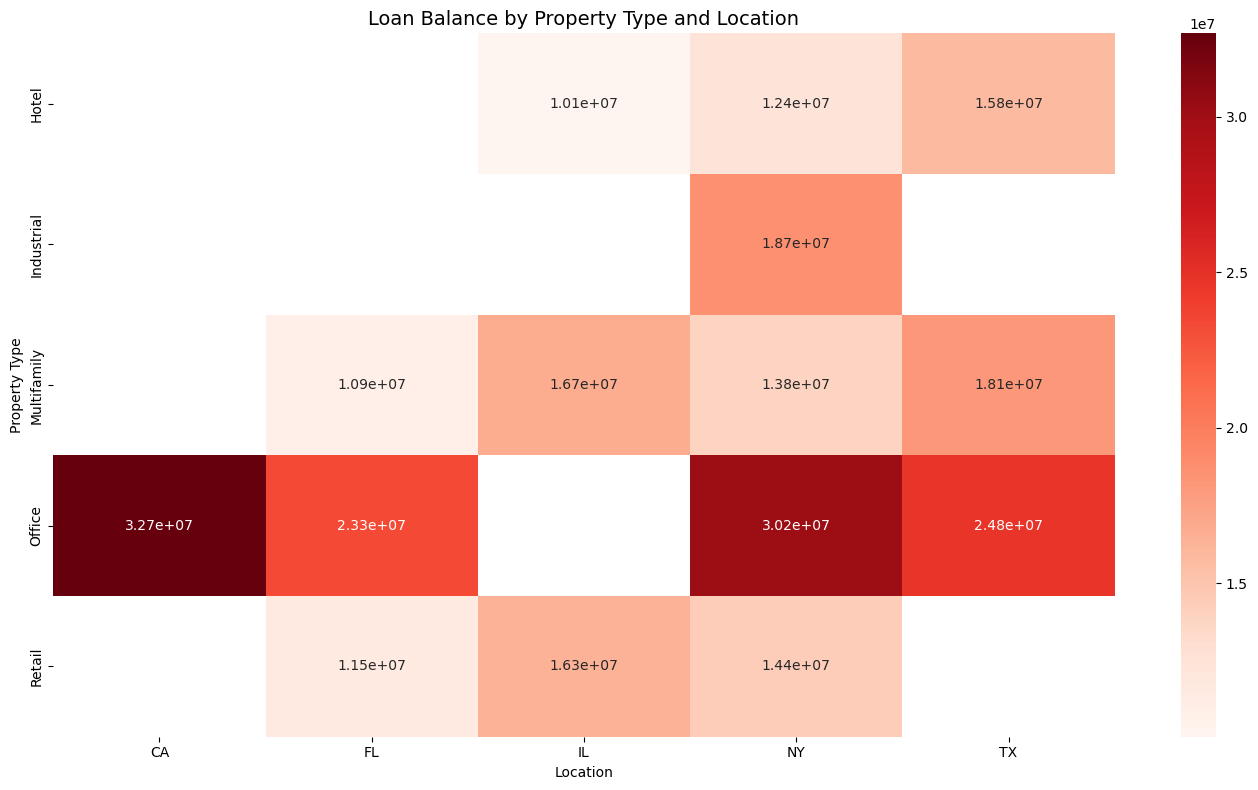

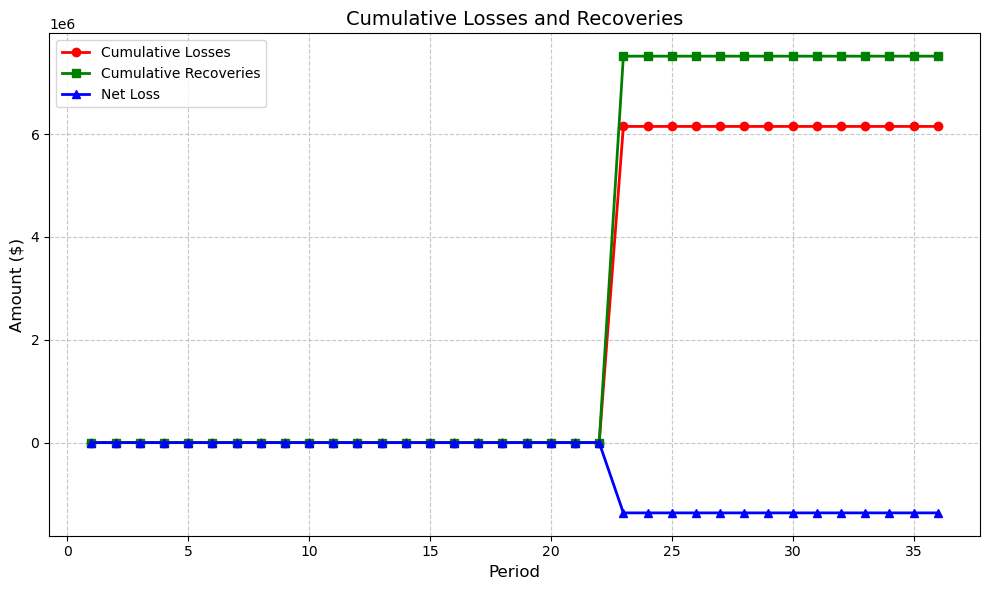

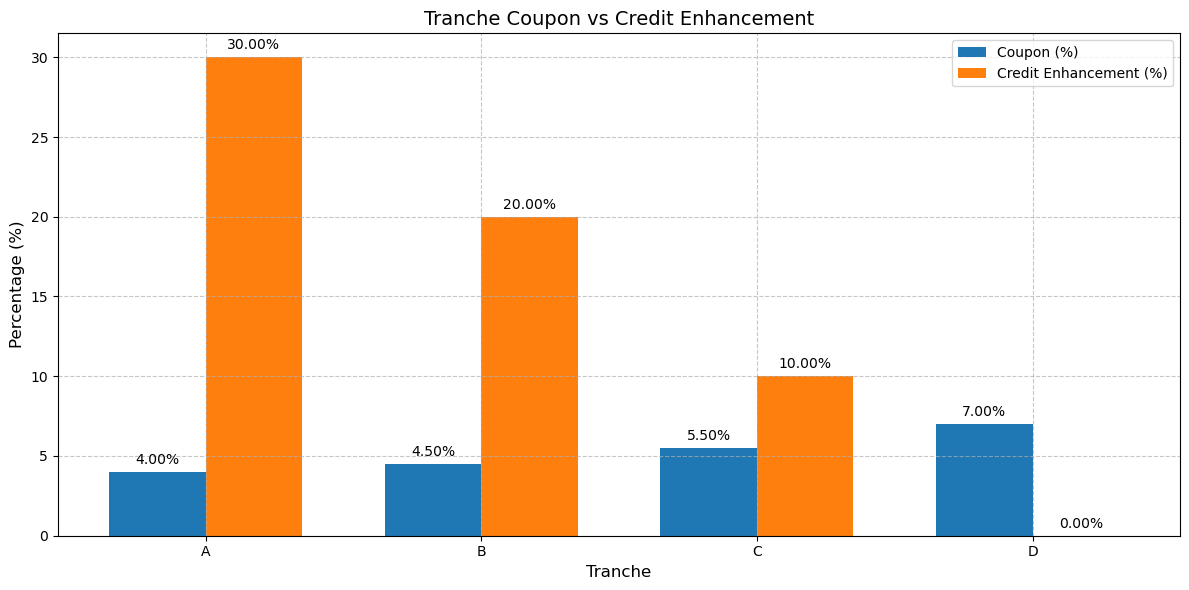

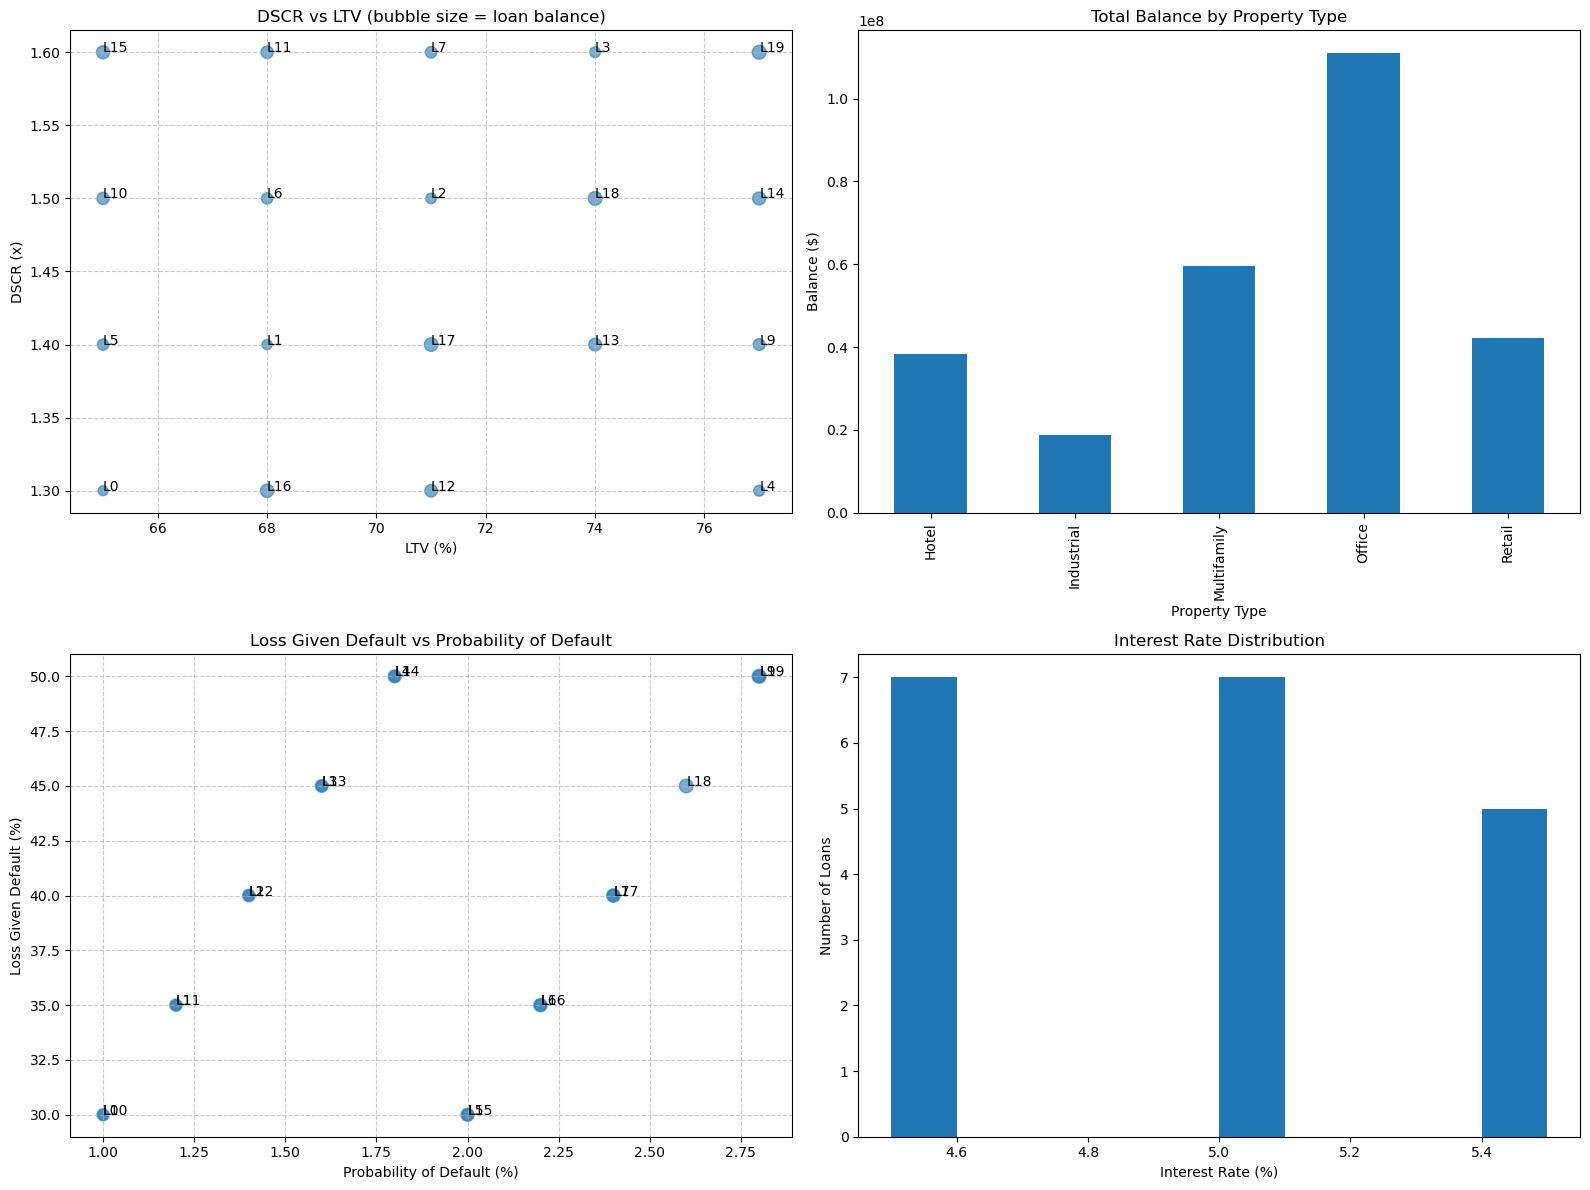

In [19]:
def plot_tranche_balances(cmbs_structure, figsize=(12, 6)):
    """
    Plot tranche balances over time to visualize the paydown of different tranches
    """
    history = cmbs_structure.payment_history
    periods = [result['period'] for result in history]
    
    # Extract tranche balances
    tranche_balances = {}
    for tranche in cmbs_structure.tranches:
        tranche_balances[tranche.id] = [result['tranche_balances'][tranche.id] for result in history]
    
    # Create plot
    plt.figure(figsize=figsize)
    for tranche_id, balances in tranche_balances.items():
        plt.plot(periods, balances, marker='o', linewidth=2, label=f"Tranche {tranche_id}")
    
    plt.title('Tranche Balance Over Time', fontsize=14)
    plt.xlabel('Period', fontsize=12)
    plt.ylabel('Balance ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    return plt

def plot_waterfall(cmbs_structure, period_index=-1, figsize=(10, 8)):
    """
    Create a waterfall chart showing distribution of cash flows for a specific period
    """
    if period_index == -1:
        period_data = cmbs_structure.payment_history[-1]
    else:
        period_data = cmbs_structure.payment_history[period_index]
    
    # Get tranche data for the period
    tranches = cmbs_structure.tranches
    
    # Calculate tranche payments
    tranche_payments = []
    previous_period_balances = {}
    
    if period_index == 0 or period_index == -1 and len(cmbs_structure.payment_history) == 1:
        # First period - use original balances
        for tranche in tranches:
            previous_period_balances[tranche.id] = tranche.original_balance
    else:
        # Get previous period balances
        prev_period = cmbs_structure.payment_history[period_index - 1 if period_index > 0 else period_index - 1]
        previous_period_balances = prev_period['tranche_balances']
    
    # Calculate principal and interest payments
    for tranche in tranches:
        current_balance = period_data['tranche_balances'][tranche.id]
        previous_balance = previous_period_balances[tranche.id]
        
        principal_payment = previous_balance - current_balance
        interest_payment = previous_balance * tranche.rate / 12
        
        tranche_payments.append({
            'tranche_id': tranche.id,
            'principal': principal_payment,
            'interest': interest_payment,
            'total': principal_payment + interest_payment
        })
    
    # Create bar chart
    plt.figure(figsize=figsize)
    
    x = np.arange(len(tranches))
    width = 0.35
    
    principal_amounts = [payment['principal'] for payment in tranche_payments]
    interest_amounts = [payment['interest'] for payment in tranche_payments]
    
    plt.bar(x, principal_amounts, width, label='Principal')
    plt.bar(x, interest_amounts, width, bottom=principal_amounts, label='Interest')
    
    plt.xlabel('Tranche')
    plt.ylabel('Payment Amount ($)')
    plt.title(f'CMBS Cash Flow Distribution - Period {period_data["period"]}')
    plt.xticks(x, [tranche.id for tranche in tranches])
    plt.legend()
    
    return plt

def plot_loan_performance_heatmap(cmbs_structure, figsize=(14, 8)):
    """
    Create a heatmap showing loan performance metrics
    """
    active_loans = [loan for loan in cmbs_structure.loans if not loan.is_defaulted]
    
    if not active_loans:
        print("No active loans to display")
        return None
    
    # Create a dataframe with loan metrics
    loan_data = []
    for loan in active_loans:
        loan_data.append({
            'Loan ID': loan.id,
            'Balance': loan.current_balance,
            'Interest Rate': loan.rate * 100,  # Convert to percentage
            'LTV': loan.ltv * 100,  # Convert to percentage
            'DSCR': loan.dscr,
            'PD': loan.probability_of_default * 100,  # Convert to percentage
            'LGD': loan.loss_given_default * 100,  # Convert to percentage
            'Property Type': loan.property_type,
            'Location': loan.location
        })
    
    loan_df = pd.DataFrame(loan_data)
    
    # Create a pivot table for the heatmap
    pivot_metrics = loan_df.pivot_table(
        index='Property Type', 
        columns='Location',
        values='Balance', 
        aggfunc='sum'
    )
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_metrics, annot=True, cmap='Reds', fmt='.2e')
    plt.title('Loan Balance by Property Type and Location', fontsize=14)
    plt.tight_layout()
    
    return plt

def plot_credit_metrics(cmbs_structure, figsize=(16, 12)):
    """
    Plot various credit metrics for the CMBS pool
    """
    active_loans = [loan for loan in cmbs_structure.loans if not loan.is_defaulted]
    
    if not active_loans:
        print("No active loans to display")
        return None
    
    # Create a dataframe with loan metrics
    loan_df = pd.DataFrame([{
        'Loan ID': loan.id,
        'Balance': loan.current_balance,
        'Interest Rate': loan.rate * 100,
        'LTV': loan.ltv * 100,
        'DSCR': loan.dscr,
        'PD': loan.probability_of_default * 100,
        'LGD': loan.loss_given_default * 100,
        'Property Type': loan.property_type,
        'Location': loan.location
    } for loan in active_loans])
    
    # Normalize loan balances for sizing
    loan_df['NormalizedBalance'] = loan_df['Balance'] / loan_df['Balance'].max() * 100
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: DSCR vs LTV with balance as bubble size
    axes[0, 0].scatter(
        loan_df['LTV'], 
        loan_df['DSCR'],
        s=loan_df['NormalizedBalance'],
        alpha=0.6
    )
    for i, row in loan_df.iterrows():
        axes[0, 0].annotate(row['Loan ID'], (row['LTV'], row['DSCR']))
        
    axes[0, 0].set_title('DSCR vs LTV (bubble size = loan balance)')
    axes[0, 0].set_xlabel('LTV (%)')
    axes[0, 0].set_ylabel('DSCR (x)')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Property Type Balance Distribution
    loan_df.groupby('Property Type')['Balance'].sum().plot(
        kind='bar',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Total Balance by Property Type')
    axes[0, 1].set_ylabel('Balance ($)')
    
    # Plot 3: PD vs LGD
    axes[1, 0].scatter(
        loan_df['PD'],
        loan_df['LGD'],
        s=loan_df['NormalizedBalance'],
        alpha=0.6
    )
    for i, row in loan_df.iterrows():
        axes[1, 0].annotate(row['Loan ID'], (row['PD'], row['LGD']))
        
    axes[1, 0].set_title('Loss Given Default vs Probability of Default')
    axes[1, 0].set_xlabel('Probability of Default (%)')
    axes[1, 0].set_ylabel('Loss Given Default (%)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot 4: Interest Rate Distribution
    axes[1, 1].hist(loan_df['Interest Rate'], bins=10)
    axes[1, 1].set_title('Interest Rate Distribution')
    axes[1, 1].set_xlabel('Interest Rate (%)')
    axes[1, 1].set_ylabel('Number of Loans')
    
    plt.tight_layout()
    return plt

def plot_losses_and_recoveries(cmbs_structure, figsize=(10, 6)):
    """
    Plot cumulative losses and recoveries over time
    """
    history = cmbs_structure.payment_history
    periods = [result['period'] for result in history]
    
    # Calculate cumulative losses and recoveries
    cumulative_losses = []
    cumulative_recoveries = []
    running_loss = 0
    running_recovery = 0
    
    for result in history:
        running_loss += result['losses']
        running_recovery += result['recoveries']
        cumulative_losses.append(running_loss)
        cumulative_recoveries.append(running_recovery)
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.plot(periods, cumulative_losses, marker='o', linewidth=2, color='red', label='Cumulative Losses')
    plt.plot(periods, cumulative_recoveries, marker='s', linewidth=2, color='green', label='Cumulative Recoveries')
    
    # Plot net loss
    net_loss = [loss - recovery for loss, recovery in zip(cumulative_losses, cumulative_recoveries)]
    plt.plot(periods, net_loss, marker='^', linewidth=2, color='blue', label='Net Loss')
    
    plt.title('Cumulative Losses and Recoveries', fontsize=14)
    plt.xlabel('Period', fontsize=12)
    plt.ylabel('Amount ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    return plt

def plot_tranche_yield_profile(cmbs_structure, figsize=(12, 6)):
    """
    Plot the yield profile of each tranche
    """
    tranche_metrics = cmbs_structure.calculate_tranche_metrics()
    
    # Create plot
    plt.figure(figsize=figsize)
    tranche_ids = tranche_metrics['tranche_id'].values
    coupons = tranche_metrics['coupon'].values
    credit_enhancement = tranche_metrics['credit_enhancement'].values
    
    x = np.arange(len(tranche_ids))
    width = 0.35
    
    plt.bar(x - width/2, coupons, width, label='Coupon (%)')
    plt.bar(x + width/2, credit_enhancement, width, label='Credit Enhancement (%)')
    
    for i, (c, ce) in enumerate(zip(coupons, credit_enhancement)):
        plt.text(i - width/2, c + 0.5, f'{c:.2f}%', ha='center')
        plt.text(i + width/2, ce + 0.5, f'{ce:.2f}%', ha='center')
    
    plt.title('Tranche Coupon vs Credit Enhancement', fontsize=14)
    plt.xlabel('Tranche', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(x, tranche_ids)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    return plt

def create_dashboard(cmbs_structure):
    """
    Create a comprehensive dashboard with multiple visualizations
    """
    # Run simulation if needed
    if not cmbs_structure.payment_history:
        cmbs_structure.run_to_maturity()
    
    # Create visualizations
    plt.figure(figsize=(20, 20))
    
    # Layout: 3 rows, 2 columns
    plt1 = plt.subplot(3, 2, 1)
    plot_tranche_balances(cmbs_structure)
    
    plt2 = plt.subplot(3, 2, 2)
    plot_losses_and_recoveries(cmbs_structure)
    
    plt3 = plt.subplot(3, 2, 3)
    plot_waterfall(cmbs_structure)
    
    plt4 = plt.subplot(3, 2, 4)
    plot_tranche_yield_profile(cmbs_structure)
    
    plt5 = plt.subplot(3, 2, 5)
    plot_loan_performance_heatmap(cmbs_structure)
    
    plt6 = plt.subplot(3, 2, 6)
    # Additional visualization
    
    plt.tight_layout()
    return plt

# Example usage:
def visualize_cmbs_example():
    """Run a sample visualization"""
    cmbs = create_sample_cmbs()
    
    # Run for 36 months
    for _ in range(36):
        cmbs.advance_period()
    
    # Create various visualizations
    plot_tranche_balances(cmbs)
    plt.savefig('tranche_balances.png')
    
    plot_waterfall(cmbs)
    plt.savefig('waterfall.png')
    
    plot_loan_performance_heatmap(cmbs)
    plt.savefig('loan_heatmap.png')
    
    plot_losses_and_recoveries(cmbs)
    plt.savefig('losses_recoveries.png')
    
    plot_tranche_yield_profile(cmbs)
    plt.savefig('yield_profile.png')
    
    plot_credit_metrics(cmbs)
    plt.savefig('credit_metrics.png')
    
    print("Visualizations created and saved.")

if __name__ == "__main__":
    visualize_cmbs_example()